In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import random

#Importing Data and Gathering closing prices for the past 3 months.

In [22]:
wipro_stock = pd.read_csv('/content/WIT.csv', usecols=['Close'])
techmahindra_stock = pd.read_csv('/content/TECHM.NS.csv', usecols=['Close'])
reliance_stock = pd.read_csv('/content/RELIANCE.NS.csv', usecols=['Close'])
tatamotors_stock = pd.read_csv('/content/TATAMOTORS.NS.csv', usecols=['Close'])
infosys_stock = pd.read_csv('/content/INFY.NS.csv', usecols=['Close'])
hyundai_stock = pd.read_csv('/content/HYMTF.csv', usecols=['Close'])

In [23]:
hdfc_etf = pd.read_csv('/content/Quote-Equity-HDFCPVTBAN-EQ-04-11-2023-to-04-02-2024.csv', usecols=['close '])[::-1].reset_index(drop=True)
icici_etf = pd.read_csv('/content/Quote-Equity-ICICIB22-EQ-04-11-2023-to-04-02-2024.csv', usecols=['close '])[::-1].reset_index(drop=True)
kotak_etf = pd.read_csv('/content/Quote-Equity-KOTAKPSUBK-EQ-04-11-2023-to-04-02-2024.csv', usecols=['close '])[::-1].reset_index(drop=True)
motilal_etf = pd.read_csv('/content/Quote-Equity-MOHEALTH-EQ-04-11-2023-to-04-02-2024.csv', usecols=['close '])[::-1].reset_index(drop=True)

In [24]:
hdfc_etf.rename(columns={'close ': 'Close'}, inplace=True)
icici_etf.rename(columns={'close ': 'Close'}, inplace=True)
kotak_etf.rename(columns={'close ': 'Close'}, inplace=True)
motilal_etf.rename(columns={'close ': 'Close'}, inplace=True)

In [25]:
# Removing last row in ETFs because today's price might not be updated.
hdfc_etf.drop(hdfc_etf.index[-1], inplace=True)
icici_etf.drop(icici_etf.index[-1], inplace=True)
kotak_etf.drop(kotak_etf.index[-1], inplace=True)
motilal_etf.drop(motilal_etf.index[-1], inplace=True)

#Calculating log returns for each asset

In [26]:
def calculate_log_returns(df):
  log_returns = np.log(df['Close'] / df['Close'].shift(1))
  return log_returns

In [27]:
# Calculating log returns for each day for each stock.
assets = [wipro_stock, techmahindra_stock, reliance_stock, tatamotors_stock, infosys_stock, hyundai_stock, hdfc_etf, icici_etf, kotak_etf, motilal_etf]
asset_names = [
    'Wipro (Stock)',
    'Tech Mahindra (Stock)',
    'Reliance (Stock)',
    'Tata Motors (Stock)',
    'Infosys (Stock)',
    'Hyundai (Stock)',
    'HDFC (ETF)',
    'ICICI (ETF)',
    'Kotak (ETF)',
    'Motilal (ETF)'
]

for asset in assets:
  asset['Log_Returns'] = calculate_log_returns(asset)
  asset.dropna(inplace=True)

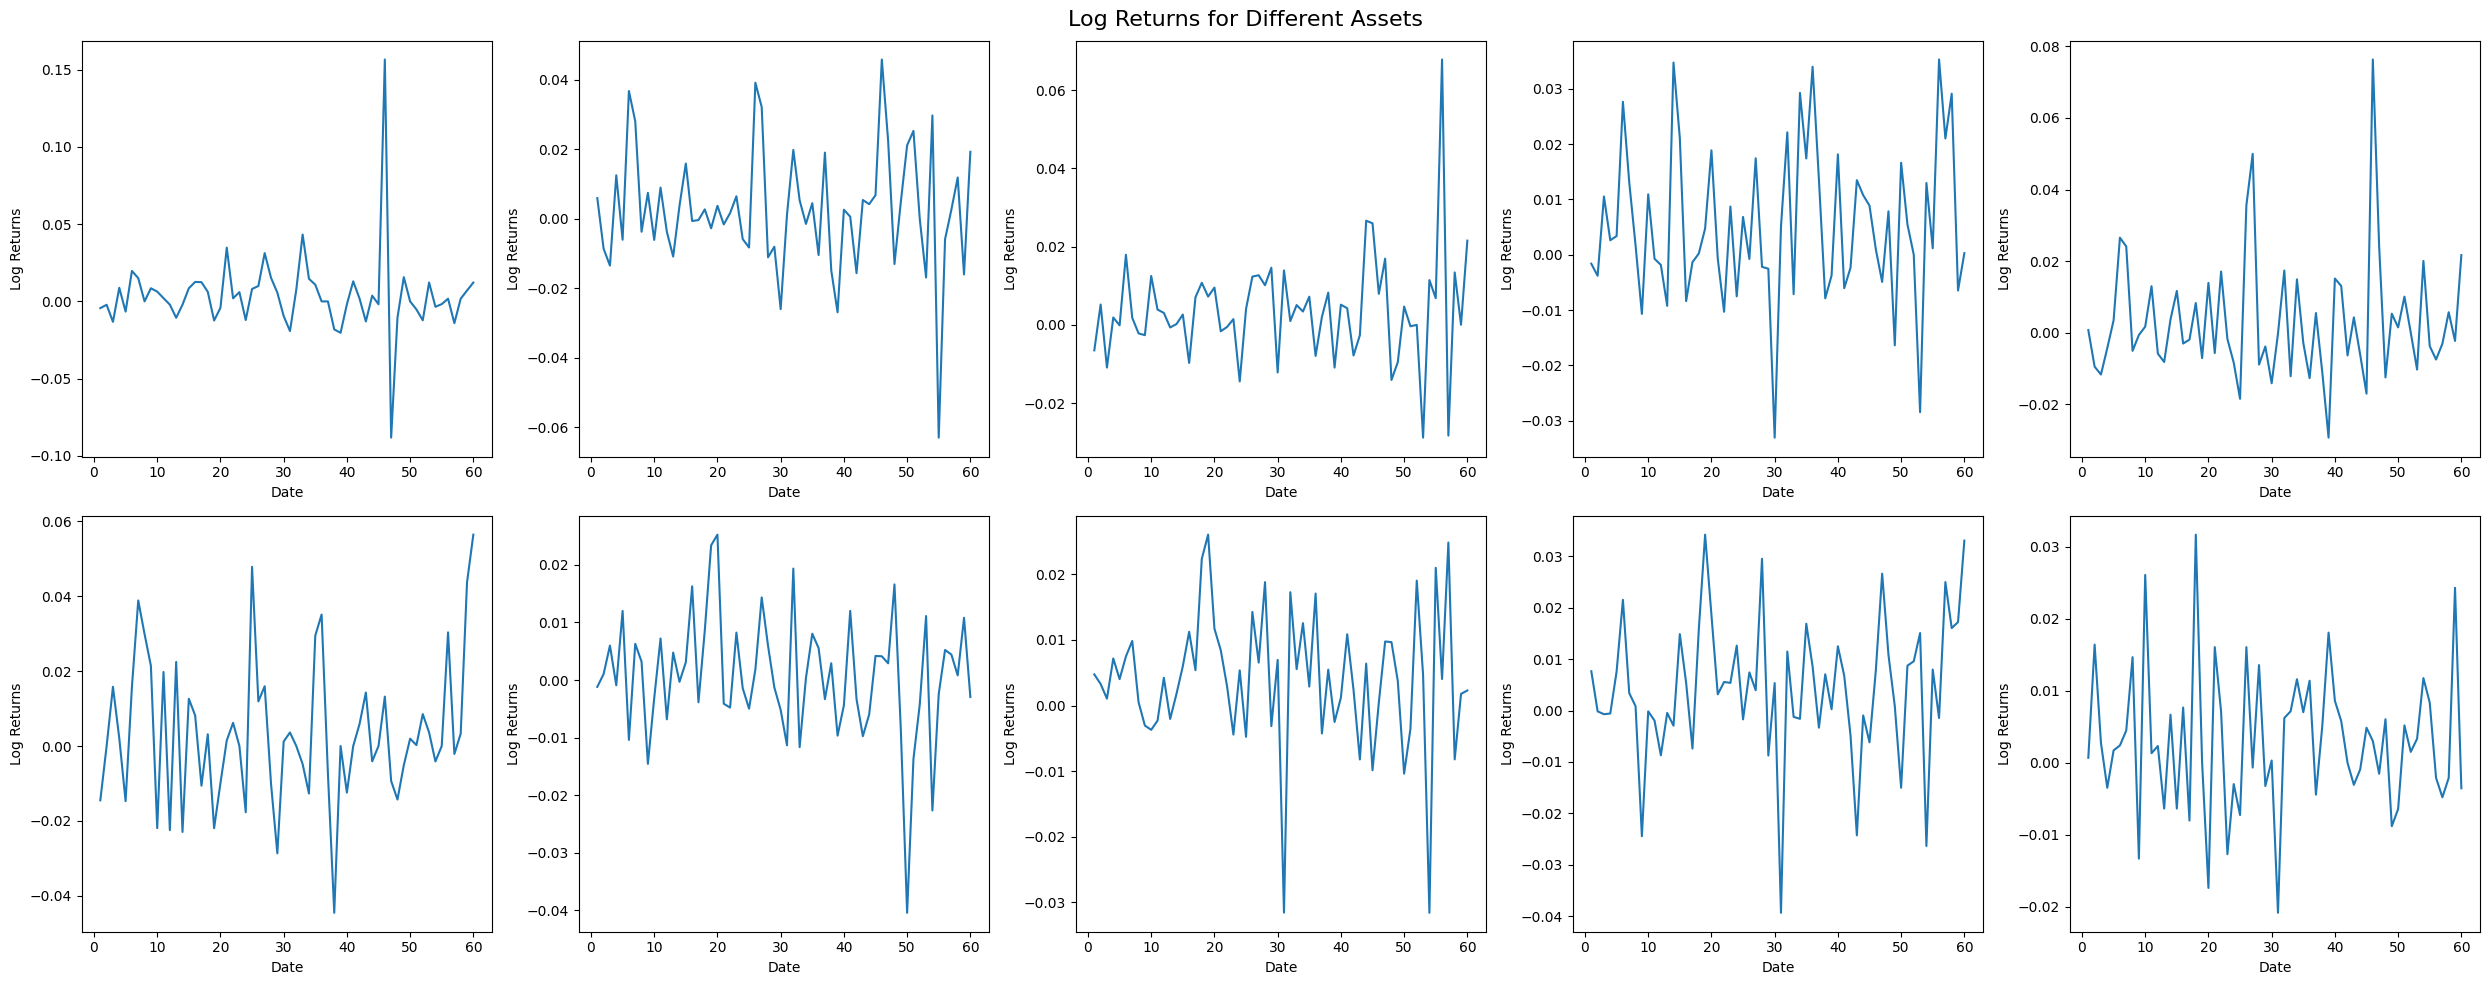

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Log Returns for Different Assets', fontsize=16)
axes = axes.flatten()

for i, asset in enumerate(assets):
  axes[i].plot(asset['Log_Returns'])
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Log Returns')

plt.tight_layout()
plt.show()

In [29]:
# Calculating average log returns for each asset.

mean_log_returns = []
for i, asset in enumerate(assets):
  mean = asset['Log_Returns'].mean()
  mean_log_returns.append(mean)
  print(asset_names[i], ':', mean)

Wipro (Stock) : 0.0037769296170826446
Tech Mahindra (Stock) : 0.00263897012100306
Reliance (Stock) : 0.0036713918406855715
Tata Motors (Stock) : 0.005127059358850992
Infosys (Stock) : 0.0031313693421298867
Hyundai (Stock) : 0.0034658355483898943
HDFC (ETF) : 0.0006466004097529448
ICICI (ETF) : 0.003991802084082278
Kotak (ETF) : 0.004366152549971801
Motilal (ETF) : 0.003026938969115922


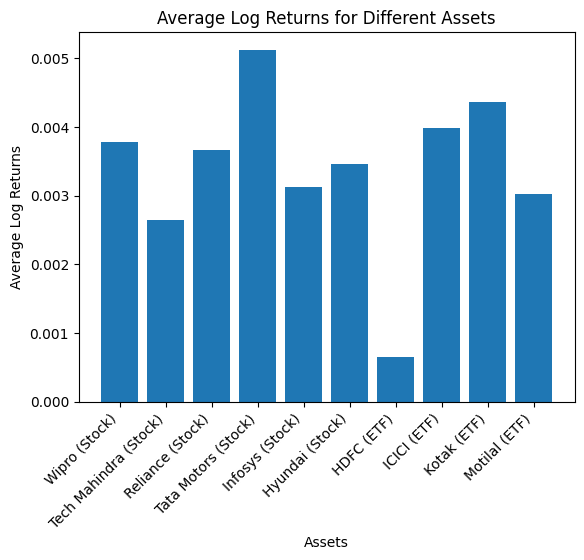

In [30]:
plt.bar(asset_names, mean_log_returns)
plt.xlabel('Assets')
plt.ylabel('Average Log Returns')
plt.title('Average Log Returns for Different Assets')
plt.xticks(rotation=45, ha='right')
plt.show()

##Applying Markowitz's mean-variance optimization to construct the efficient frontier

In [31]:
import cvxpy as cp

C = []
for asset1 in assets:
  corr_var = []
  for asset2 in assets:
    element = asset1['Log_Returns'].corr(asset2['Log_Returns']) * asset1['Log_Returns'].var() * asset2['Log_Returns'].var()
    corr_var.append(element)
  C.append(corr_var)
C = np.array(C)

weights = cp.Variable(len(assets))
objective = cp.Maximize(weights @ mean_log_returns)
constraints = [cp.sum(weights) == 1, weights >= 0]
problem = cp.Problem(objective, constraints)
expected_return_opt = problem.solve()
optimal_weights = weights.value
optimal_weights_matrix = optimal_weights.reshape(-1, 1) @ optimal_weights.reshape(1, -1)
matrix = optimal_weights_matrix * C
risk_opt = np.sum(matrix)

In [33]:
weights.value

array([9.65975867e-09, 7.47339069e-09, 9.70933647e-09, 9.99999931e-01,
       8.72171028e-09, 9.48414780e-09, 4.36426134e-09, 8.88388998e-09,
       2.04451893e-09, 8.45218539e-09])

In [14]:
import random

weights_list = []
points = 1000
for i in range(points):
  weights = [random.uniform(0, 1) for _ in range(9)]
  weights.append(1 - np.sum(weights))
  random.shuffle(weights)
  weights_list.append(weights)
weights_list = np.array(weights_list)

In [15]:
efficient_frontier = []
for weights in weights_list:
  expected_return = weights @ mean_log_returns
  weights_matrix = weights.reshape(-1, 1) @ weights.reshape(1, -1)
  matrix = weights_matrix * C
  risk = np.sum(matrix)
  efficient_frontier.append([risk, expected_return])
efficient_frontier = np.array(efficient_frontier)

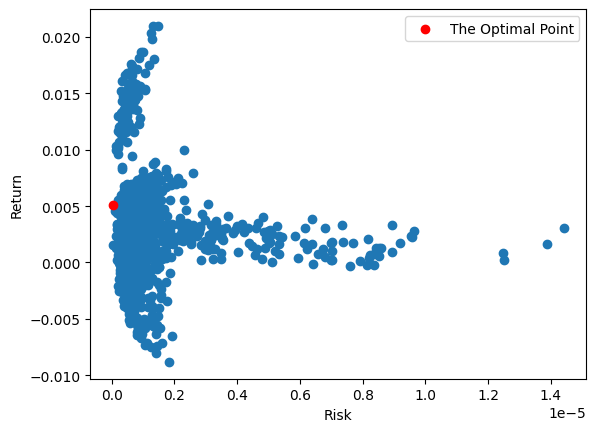

In [17]:
plt.scatter(efficient_frontier[:, 0], efficient_frontier[:, 1])
plt.scatter(risk_opt, expected_return_opt, color='red', label='The Optimal Point')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend()
plt.show()

In [18]:
efficient_frontier

array([[ 7.04010817e-07, -3.79136459e-04],
       [ 1.30830821e-06,  2.09649307e-02],
       [ 1.26306103e-06,  2.38330099e-03],
       ...,
       [ 1.46890446e-06,  3.31869452e-03],
       [ 5.88914300e-07,  2.84074287e-03],
       [ 9.86401031e-07,  4.08968490e-03]])